<a href="https://colab.research.google.com/github/Mehdi007bond/Predictive_maintenance_Project/blob/main/Predictive_maintenance_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I started by generating the dataset so i can work


In [1]:
import pandas as pd
import numpy as np
import datetime

# --- 1. Configuration Générale ---
N_LINES = 4  # Nombre de lignes de production à simuler
DAYS_PER_MACHINE = 60
SAMPLES_PER_HOUR = 4
N_SAMPLES_PER_DAY = 24 * SAMPLES_PER_HOUR
TOTAL_SAMPLES_PER_MACHINE = DAYS_PER_MACHINE * N_SAMPLES_PER_DAY

# --- Paramètres de simulation (MIS À JOUR) ---
# Notre "état de panne" (cible=1) commence 58h avant la panne
# pour atteindre notre objectif de 4.02%
FAILURE_STATE_HOURS = 58
FAILURE_STATE_SAMPLES = FAILURE_STATE_HOURS * SAMPLES_PER_HOUR

# --- 2. Profils des Machines ---
def get_machine_parameters(machine_type):
    """Définit les profils de capteurs et de défaillance pour chaque type de machine."""

    if machine_type == 'Fraiseuse':
        return {
            'BASE_TEMP': 45.0, 'TEMP_NOISE': 2.0, 'TEMP_DEGRADE_RATE': 0.1,
            'BASE_VIB': 1.2, 'VIB_NOISE': 0.3, 'VIB_DEGRADE_RATE': 0.1,
            'BASE_CUR': 10.0, 'CUR_NOISE': 0.5, 'CUR_DEGRADE_RATE': 0.08,
            'BASE_TORQUE': 80.0, 'TORQUE_NOISE': 3.0, 'TORQUE_DEGRADE_RATE': 0.15
        }
    elif machine_type == 'Convoyeur':
        return {
            'BASE_TEMP': 30.0, 'TEMP_NOISE': 1.0, 'TEMP_DEGRADE_RATE': 0.05,
            'BASE_VIB': 0.4, 'VIB_NOISE': 0.1, 'VIB_DEGRADE_RATE': 0.03,
            'BASE_CUR': 3.0, 'CUR_NOISE': 0.1, 'CUR_DEGRADE_RATE': 0.15,
            'BASE_TORQUE': 20.0, 'TORQUE_NOISE': 1.0, 'TORQUE_DEGRADE_RATE': 0.05
        }
    elif machine_type == 'Machine_de_finition':
        return {
            'BASE_TEMP': 35.0, 'TEMP_NOISE': 0.5, 'TEMP_DEGRADE_RATE': 0.03,
            'BASE_VIB': 0.2, 'VIB_NOISE': 0.05, 'VIB_DEGRADE_RATE': 0.08,
            'BASE_CUR': 2.0, 'CUR_NOISE': 0.1, 'CUR_DEGRADE_RATE': -0.05,
            'BASE_TORQUE': 10.0, 'TORQUE_NOISE': 0.5, 'TORQUE_DEGRADE_RATE': -0.02
        }
    else:
        raise ValueError("Type de machine inconnu")

# --- 3. Fonction de Génération (Simplifiée) ---
def generate_machine_data(machine_id, machine_type, production_line, start_date):

    print(f"Génération des données pour Machine ID: {machine_id} (Type: {machine_type})...")

    params = get_machine_parameters(machine_type)
    total_samples = TOTAL_SAMPLES_PER_MACHINE

    time_offset_seconds = np.random.randint(0, 30)
    base_timestamps = [start_date + datetime.timedelta(hours=i/SAMPLES_PER_HOUR) for i in range(total_samples)]
    timestamps = [ts + datetime.timedelta(seconds=time_offset_seconds) for ts in base_timestamps]

    # Initialisation des capteurs
    temp = np.random.normal(loc=params['BASE_TEMP'], scale=params['TEMP_NOISE'], size=total_samples)
    vib = np.random.normal(loc=params['BASE_VIB'], scale=params['VIB_NOISE'], size=total_samples)
    curr = np.random.normal(loc=params['BASE_CUR'], scale=params['CUR_NOISE'], size=total_samples)
    torque = np.random.normal(loc=params['BASE_TORQUE'], scale=params['TORQUE_NOISE'], size=total_samples)

    # Feature "Odomètre": total_working_hours
    total_working_hours = (np.arange(total_samples) / SAMPLES_PER_HOUR).round(2)

    # --- CIBLE ML (Simplifiée) ---
    # 0 = 'Healthy', 1 = 'Failing'
    failure = np.zeros(total_samples, dtype=int)

    # Définir le point de panne exact
    failure_sample = total_samples - np.random.randint(N_SAMPLES_PER_DAY * 3, N_SAMPLES_PER_DAY * 15)

    # L'état de panne commence 58h avant
    failing_state_start_sample = failure_sample - FAILURE_STATE_SAMPLES

    # Mettre la cible à 1 pendant l'état de panne
    failure[failing_state_start_sample:failure_sample] = 1

    # Appliquer la dégradation des capteurs PENDANT l'état de panne
    for i in range(failing_state_start_sample, failure_sample):
        progress = (i - failing_state_start_sample) / (failure_sample - failing_state_start_sample)
        temp[i] += params['TEMP_DEGRADE_RATE'] * progress * 20
        vib[i] += params['VIB_DEGRADE_RATE'] * progress * 15
        curr[i] += params['CUR_DEGRADE_RATE'] * progress * 10
        torque[i] += params['TORQUE_DEGRADE_RATE'] * progress * 10

    # --- Assemblage du DataFrame (Simplifié) ---
    df = pd.DataFrame({
        'timestamp': timestamps,
        'production_line': production_line,
        'machine_id': machine_id,
        'machine_type': machine_type,
        'temperature': temp.round(2),
        'vibration': vib.round(4),
        'current': curr.round(3),
        'torque': torque.round(2),
        'total_working_hours': total_working_hours,
        'failure': failure                  # NOTRE CIBLE ML (0 ou 1)
    })

    return df

# --- 4. Boucle Principale de Génération ---
print("Démarrage de la génération du dataset (Cible = failure)...")
all_data_frames = []
start_date = datetime.datetime(2024, 1, 1)
machine_id_counter = 1
machine_types = ['Fraiseuse', 'Convoyeur', 'Machine_de_finition']

for i in range(N_LINES):
    line_name = f"Line_{i+1}"
    print(f"\n--- Génération des données pour {line_name} ---")
    for machine_type in machine_types:
        machine_df = generate_machine_data(
            machine_id=machine_id_counter,
            machine_type=machine_type,
            production_line=line_name,
            start_date=start_date
        )
        all_data_frames.append(machine_df)
        machine_id_counter += 1

# --- 5. Finalisation : Mélange et Sauvegarde ---
print("\nFinalisation du dataset...")
full_dataset = pd.concat(all_data_frames)

print("Tri du dataset par timestamp pour simuler la collecte 'temps réel'...")
full_dataset.sort_values(by='timestamp', inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

print("\nDataset de CLASSIFICATION (4%) généré et mélangé !")
print(f"Nombre total d'échantillons: {len(full_dataset)}")

# Sauvegarde
output_filename = "production_line_STATE_BASED_4_PERCENT_data.csv"
full_dataset.to_csv(output_filename, index=False)
print(f"Dataset sauvegardé sous '{output_filename}'")

# Affichage d'un échantillon
print("\n--- Aperçu du Dataset ---")
print(full_dataset.head(10))

print("\n--- Distribution de la Cible (failure) ---")
print(full_dataset['failure'].value_counts())
target_rate = full_dataset['failure'].mean() * 100
print(f"Pourcentage de 'failure' (1): {target_rate:.2f}%")

Démarrage de la génération du dataset (Cible = failure)...

--- Génération des données pour Line_1 ---
Génération des données pour Machine ID: 1 (Type: Fraiseuse)...
Génération des données pour Machine ID: 2 (Type: Convoyeur)...
Génération des données pour Machine ID: 3 (Type: Machine_de_finition)...

--- Génération des données pour Line_2 ---
Génération des données pour Machine ID: 4 (Type: Fraiseuse)...
Génération des données pour Machine ID: 5 (Type: Convoyeur)...
Génération des données pour Machine ID: 6 (Type: Machine_de_finition)...

--- Génération des données pour Line_3 ---
Génération des données pour Machine ID: 7 (Type: Fraiseuse)...
Génération des données pour Machine ID: 8 (Type: Convoyeur)...
Génération des données pour Machine ID: 9 (Type: Machine_de_finition)...

--- Génération des données pour Line_4 ---
Génération des données pour Machine ID: 10 (Type: Fraiseuse)...
Génération des données pour Machine ID: 11 (Type: Convoyeur)...
Génération des données pour Machine ID: 

# Starting by exploratory data analysis

In [2]:
df = full_dataset
display(df.head(10))
display(df.shape)
df.isna().sum()
display(df.describe())
#


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure
0,2024-01-01 00:00:00,Line_3,8,Convoyeur,27.97,0.4722,3.260,19.92,0.0,0
1,2024-01-01 00:00:03,Line_1,3,Machine_de_finition,35.09,0.2203,1.996,10.23,0.0,0
2,2024-01-01 00:00:03,Line_3,9,Machine_de_finition,35.08,0.2049,2.221,9.67,0.0,0
3,2024-01-01 00:00:11,Line_2,4,Fraiseuse,46.49,1.6490,9.848,78.67,0.0,0
4,2024-01-01 00:00:11,Line_4,12,Machine_de_finition,34.51,0.2211,2.209,9.48,0.0,0
5,2024-01-01 00:00:12,Line_1,1,Fraiseuse,44.30,0.7920,10.606,78.22,0.0,0
6,2024-01-01 00:00:12,Line_3,7,Fraiseuse,42.31,1.4710,9.995,79.16,0.0,0
7,2024-01-01 00:00:19,Line_2,6,Machine_de_finition,35.65,0.2295,1.914,9.06,0.0,0
8,2024-01-01 00:00:20,Line_4,11,Convoyeur,31.44,0.5058,3.170,20.74,0.0,0
9,2024-01-01 00:00:22,Line_2,5,Convoyeur,30.29,0.2940,2.954,19.93,0.0,0


(69120, 10)

,timestamp,machine_id,temperature,vibration,current,torque,total_working_hours,failure
count,69120,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000,69120.000000
mean,2024-01-30 23:52:43.666666240,6.500000,36.697813,0.621087,5.013131,36.683710,719.875000,0.040278
min,2024-01-01 00:00:00,1.000000,26.050000,-0.117100,1.323000,8.090000,0.000000,0.000000
25%,2024-01-15 23:56:22.249999872,3.750000,30.700000,0.230800,2.064000,10.330000,359.937500,0.000000
50%,2024-01-30 23:52:44.500000,6.500000,35.010000,0.411500,3.006000,20.010000,719.875000,0.000000
75%,2024-02-14 23:49:06.750000128,9.250000,43.700000,1.017400,9.676000,78.030000,1079.812500,0.000000
max,2024-02-29 23:45:29,12.000000,55.060000,3.341200,12.425000,92.200000,1439.750000,1.000000
std,NaN,3.452078,6.392004,0.491960,3.579906,30.990142,415.695195,0.196611


In [3]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69120 entries, 0 to 69119
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            69120 non-null  datetime64[ns]
 1   production_line      69120 non-null  object        
 2   machine_id           69120 non-null  int64         
 3   machine_type         69120 non-null  object        
 4   temperature          69120 non-null  float64       
 5   vibration            69120 non-null  float64       
 6   current              69120 non-null  float64       
 7   torque               69120 non-null  float64       
 8   total_working_hours  69120 non-null  float64       
 9   failure              69120 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 5.3+ MB


Index(['timestamp', 'production_line', 'machine_id', 'machine_type',
       'temperature', 'vibration', 'current', 'torque', 'total_working_hours',
       'failure'],
      dtype='object')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['failure'] :
  col_counts = df[col].value_counts()
  print(col_counts)



failure
0    66336
1     2784
Name: count, dtype: int64


array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'machine_id'}>,
        <Axes: title={'center': 'temperature'}>],
       [<Axes: title={'center': 'vibration'}>,
        <Axes: title={'center': 'current'}>,
        <Axes: title={'center': 'torque'}>],
       [<Axes: title={'center': 'total_working_hours'}>,
        <Axes: title={'center': 'failure'}>, <Axes: >]], dtype=object)

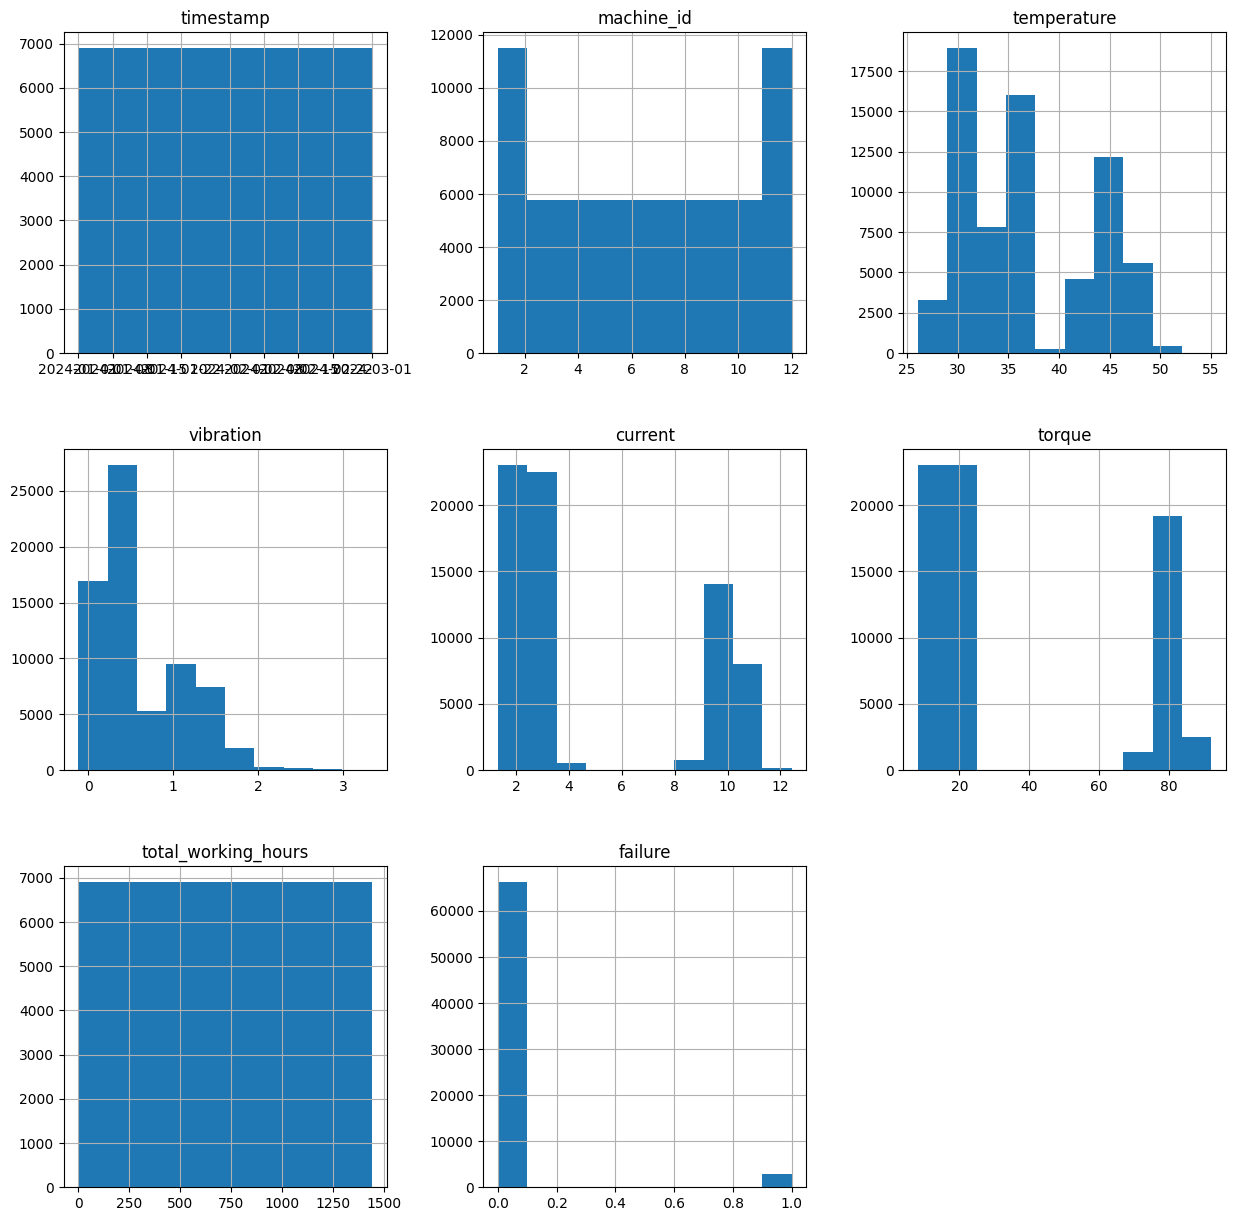

In [5]:
df.hist(figsize=(15,15))

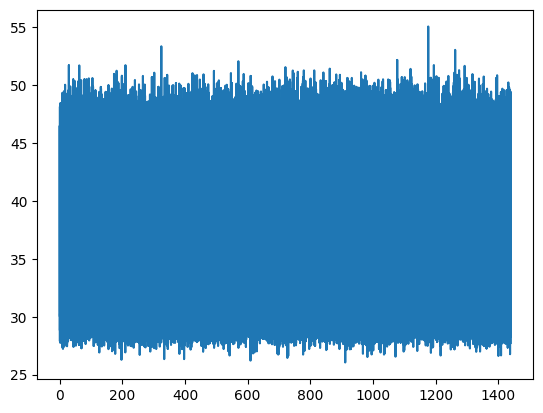

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
1,2024-01-01 00:00:03,Line_1,3,Machine_de_finition,35.09,0.2203,1.996,10.23,0.00,0,No failure
14,2024-01-01 00:15:03,Line_1,3,Machine_de_finition,34.36,0.1666,1.853,9.87,0.25,0,No failure
26,2024-01-01 00:30:03,Line_1,3,Machine_de_finition,35.59,0.1794,1.962,9.97,0.50,0,No failure
38,2024-01-01 00:45:03,Line_1,3,Machine_de_finition,34.71,0.1323,1.928,10.48,0.75,0,No failure
50,2024-01-01 01:00:03,Line_1,3,Machine_de_finition,34.62,0.1571,1.999,10.89,1.00,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69062,2024-02-29 22:45:03,Line_1,3,Machine_de_finition,34.63,0.1491,1.886,9.55,1438.75,0,No failure
69074,2024-02-29 23:00:03,Line_1,3,Machine_de_finition,34.54,0.2302,2.138,8.72,1439.00,0,No failure
69086,2024-02-29 23:15:03,Line_1,3,Machine_de_finition,33.61,0.2072,1.899,9.32,1439.25,0,No failure
69097,2024-02-29 23:30:03,Line_1,3,Machine_de_finition,35.01,0.2535,2.067,9.60,1439.50,0,No failure


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
3,2024-01-01 00:00:11,Line_2,4,Fraiseuse,46.49,1.6490,9.848,78.67,0.00,0,No failure
7,2024-01-01 00:00:19,Line_2,6,Machine_de_finition,35.65,0.2295,1.914,9.06,0.00,0,No failure
9,2024-01-01 00:00:22,Line_2,5,Convoyeur,30.29,0.2940,2.954,19.93,0.00,0,No failure
16,2024-01-01 00:15:11,Line_2,4,Fraiseuse,43.65,1.9407,9.898,76.71,0.25,0,No failure
19,2024-01-01 00:15:19,Line_2,6,Machine_de_finition,35.40,0.1800,1.957,10.43,0.25,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69103,2024-02-29 23:30:19,Line_2,6,Machine_de_finition,34.25,0.1671,1.975,10.36,1439.50,0,No failure
69106,2024-02-29 23:30:22,Line_2,5,Convoyeur,29.87,0.4834,3.094,19.26,1439.50,0,No failure
69112,2024-02-29 23:45:11,Line_2,4,Fraiseuse,43.55,1.1735,10.248,83.10,1439.75,0,No failure
69115,2024-02-29 23:45:19,Line_2,6,Machine_de_finition,35.55,0.1393,2.038,10.52,1439.75,0,No failure


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
0,2024-01-01 00:00:00,Line_3,8,Convoyeur,27.97,0.4722,3.260,19.92,0.00,0,No failure
2,2024-01-01 00:00:03,Line_3,9,Machine_de_finition,35.08,0.2049,2.221,9.67,0.00,0,No failure
6,2024-01-01 00:00:12,Line_3,7,Fraiseuse,42.31,1.4710,9.995,79.16,0.00,0,No failure
12,2024-01-01 00:15:00,Line_3,8,Convoyeur,31.08,0.4112,3.045,19.36,0.25,0,No failure
13,2024-01-01 00:15:03,Line_3,9,Machine_de_finition,34.69,0.1466,2.096,10.45,0.25,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69098,2024-02-29 23:30:03,Line_3,9,Machine_de_finition,34.72,0.1811,1.934,10.37,1439.50,0,No failure
69102,2024-02-29 23:30:12,Line_3,7,Fraiseuse,48.14,1.3719,9.667,75.65,1439.50,0,No failure
69108,2024-02-29 23:45:00,Line_3,8,Convoyeur,28.34,0.4621,3.155,18.37,1439.75,0,No failure
69110,2024-02-29 23:45:03,Line_3,9,Machine_de_finition,35.09,0.2484,1.868,9.79,1439.75,0,No failure


,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
4,2024-01-01 00:00:11,Line_4,12,Machine_de_finition,34.51,0.2211,2.209,9.48,0.00,0,No failure
8,2024-01-01 00:00:20,Line_4,11,Convoyeur,31.44,0.5058,3.170,20.74,0.00,0,No failure
10,2024-01-01 00:00:22,Line_4,10,Fraiseuse,43.63,1.4773,9.535,82.69,0.00,0,No failure
15,2024-01-01 00:15:11,Line_4,12,Machine_de_finition,34.72,0.1747,2.073,9.88,0.25,0,No failure
20,2024-01-01 00:15:20,Line_4,11,Convoyeur,29.33,0.4330,2.983,18.84,0.25,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69104,2024-02-29 23:30:20,Line_4,11,Convoyeur,33.20,0.2885,3.013,19.05,1439.50,0,No failure
69105,2024-02-29 23:30:22,Line_4,10,Fraiseuse,43.33,1.4705,9.814,82.09,1439.50,0,No failure
69111,2024-02-29 23:45:11,Line_4,12,Machine_de_finition,35.05,0.1896,2.012,10.94,1439.75,0,No failure
69116,2024-02-29 23:45:20,Line_4,11,Convoyeur,30.21,0.3845,3.176,18.60,1439.75,0,No failure


<Figure size 1500x1500 with 0 Axes>

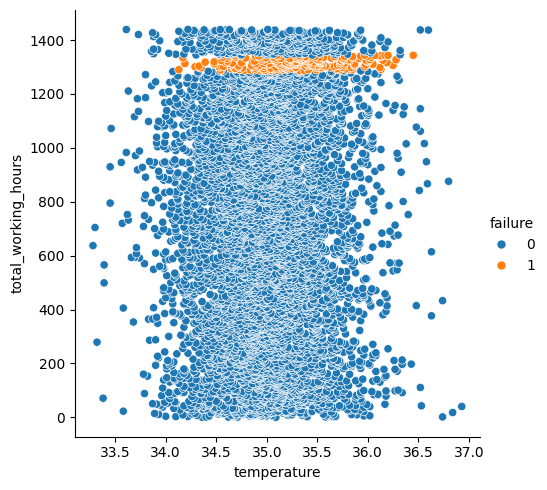

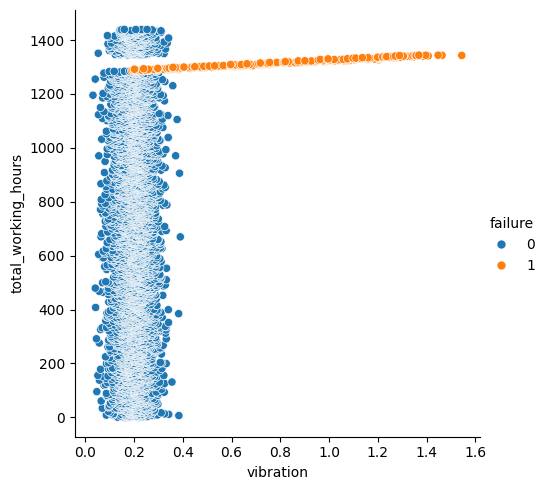

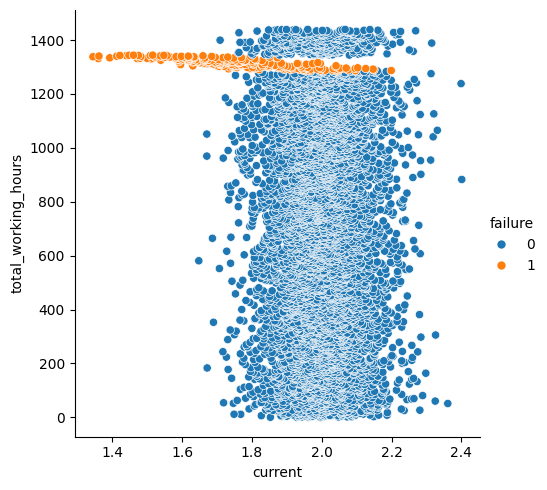

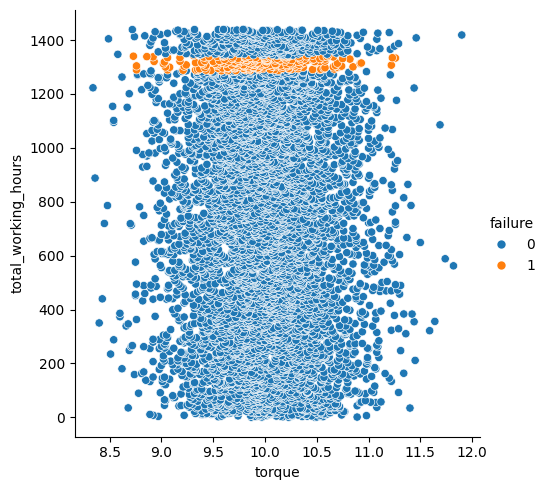

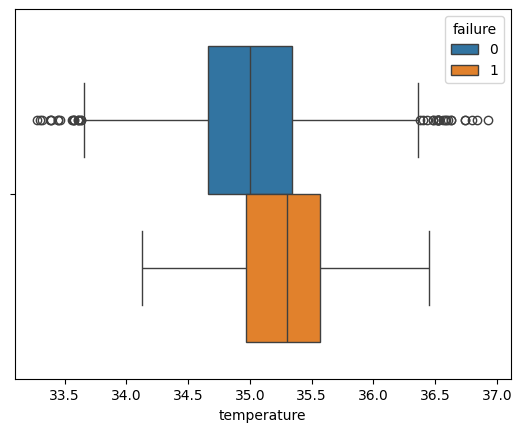

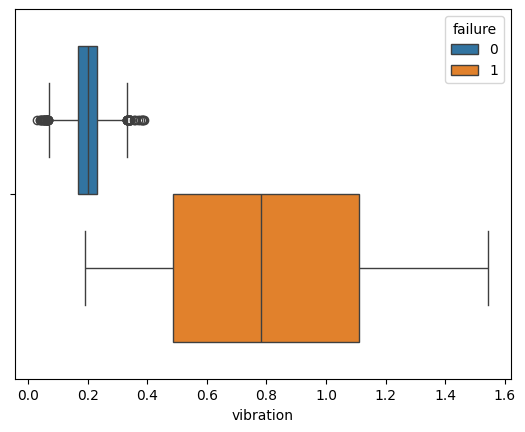

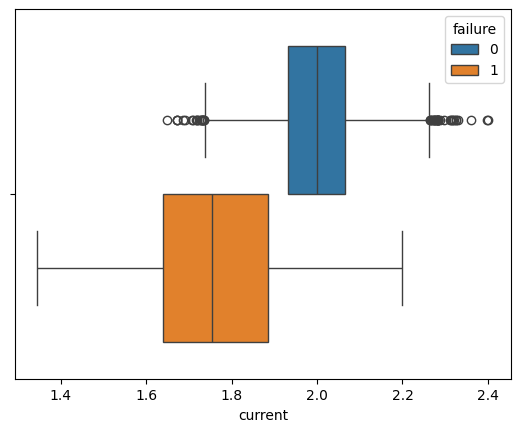

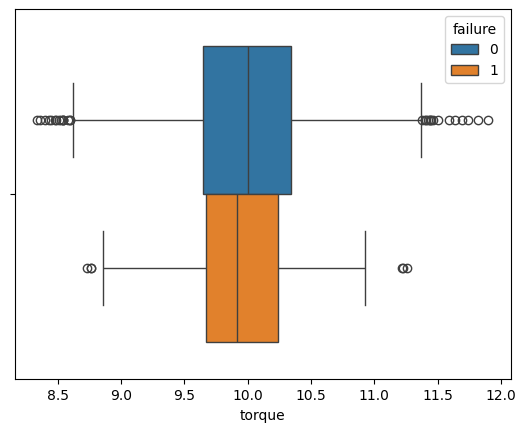

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure,Failure_Type
1,2024-01-01 00:00:03,Line_1,3,Machine_de_finition,35.09,0.2203,1.996,10.23,0.00,0,No failure
14,2024-01-01 00:15:03,Line_1,3,Machine_de_finition,34.36,0.1666,1.853,9.87,0.25,0,No failure
26,2024-01-01 00:30:03,Line_1,3,Machine_de_finition,35.59,0.1794,1.962,9.97,0.50,0,No failure
38,2024-01-01 00:45:03,Line_1,3,Machine_de_finition,34.71,0.1323,1.928,10.48,0.75,0,No failure
50,2024-01-01 01:00:03,Line_1,3,Machine_de_finition,34.62,0.1571,1.999,10.89,1.00,0,No failure
...,...,...,...,...,...,...,...,...,...,...,...
69062,2024-02-29 22:45:03,Line_1,3,Machine_de_finition,34.63,0.1491,1.886,9.55,1438.75,0,No failure
69074,2024-02-29 23:00:03,Line_1,3,Machine_de_finition,34.54,0.2302,2.138,8.72,1439.00,0,No failure
69086,2024-02-29 23:15:03,Line_1,3,Machine_de_finition,33.61,0.2072,1.899,9.32,1439.25,0,No failure
69097,2024-02-29 23:30:03,Line_1,3,Machine_de_finition,35.01,0.2535,2.067,9.60,1439.50,0,No failure


In [6]:
df.columns
failure_cols = ['temperature', 'vibration', 'current', 'torque']
def classify_failure_type(row):
  for col in failure_cols :
    if row[col] == 1 :
      return col
  return "No failure"

df["Failure_Type"] = df.apply(classify_failure_type, axis=1)


# The following line caused the ValueError and is removed:


plt.plot(df["total_working_hours"], df["temperature"], label="Temperature")
plt.show()

df.tail(100)
df_line2= df[(df['production_line'] == 'Line_2')]
df_line2
df_line1= df[(df['production_line'] == 'Line_1')]
df_line1
df_line3= df[(df['production_line'] == 'Line_3')]
df_line3
df_line4= df[(df['production_line'] == 'Line_4')]
# building a plot where we can see a evolution of each line (1 2 3)
#making a classification of each variable so we ca ddisplay it
df_line1 = df[(df['production_line'] == 'Line_1') & (df['machine_type'] == 'Machine_de_finition')]
criteria=['temperature', 'vibration', 'current', 'torque']


df.head()
display(df_line1 , df_line2 ,df_line3 ,df_line4)
plt.figure(figsize=(15,15))
for i in criteria:
  sns.relplot(x=i ,y='total_working_hours', hue='failure' , data=df_line1)
  plt.show()
for b in criteria:
  sns.boxplot(x=b , hue='failure' , data=df_line1)
  plt.show()
display(df_line1)

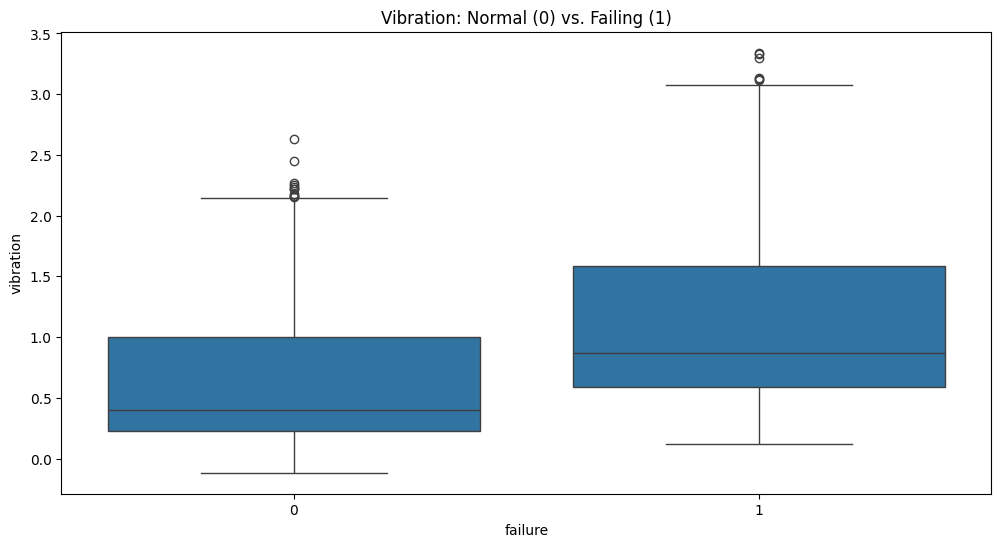

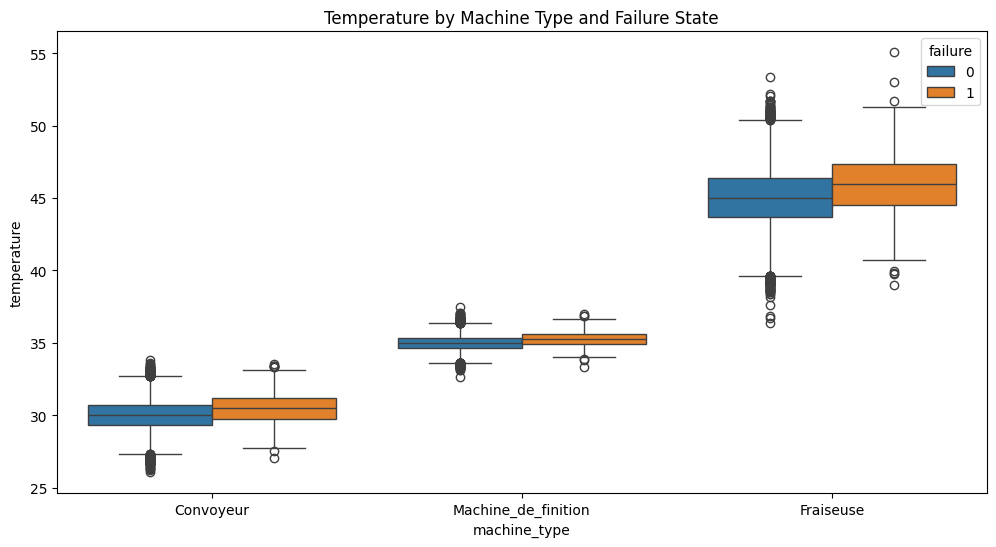

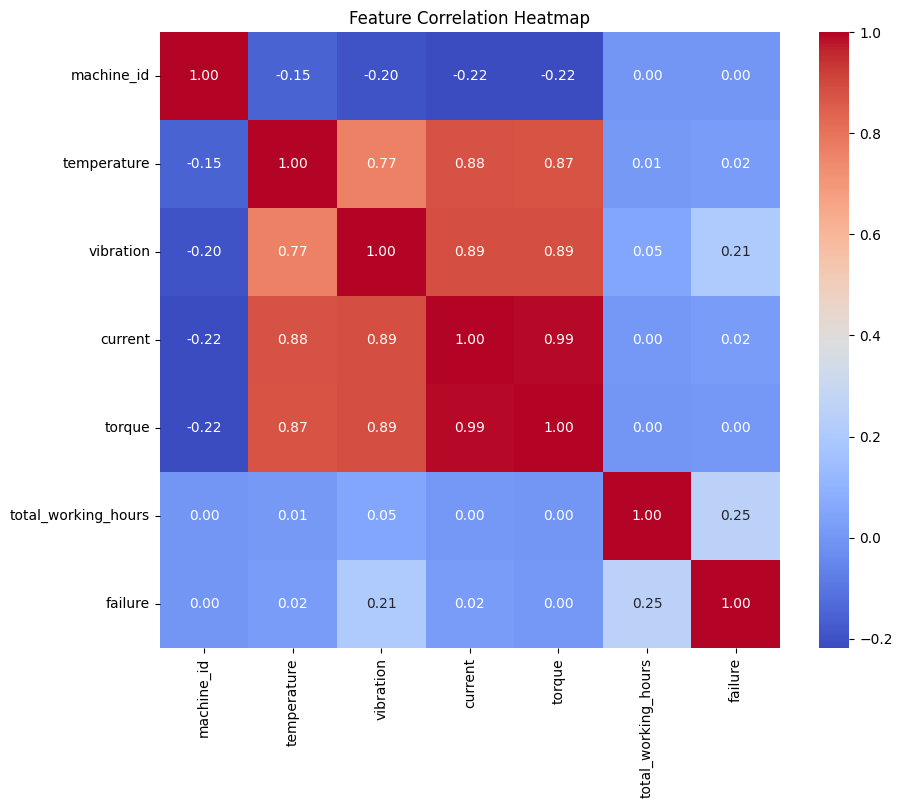

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. See the difference between Normal (0) and Failing (1) states

plt.figure(figsize=(12, 6))
sns.boxplot(x='failure', y='vibration', data=df)
plt.title('Vibration: Normal (0) vs. Failing (1)')
plt.show()

# 2. Compare machine types

plt.figure(figsize=(12, 6))
sns.boxplot(x='machine_type', y='temperature', hue='failure', data=df)
plt.title('Temperature by Machine Type and Failure State')
plt.show()

# 3. Check correlations

numeric_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [8]:
# Display the correlation between 'current' and 'torque'
print("Correlation between Current and Torque:")
print(numeric_cols.corr().loc['current', 'torque'])

Correlation between Current and Torque:
0.994161143421743


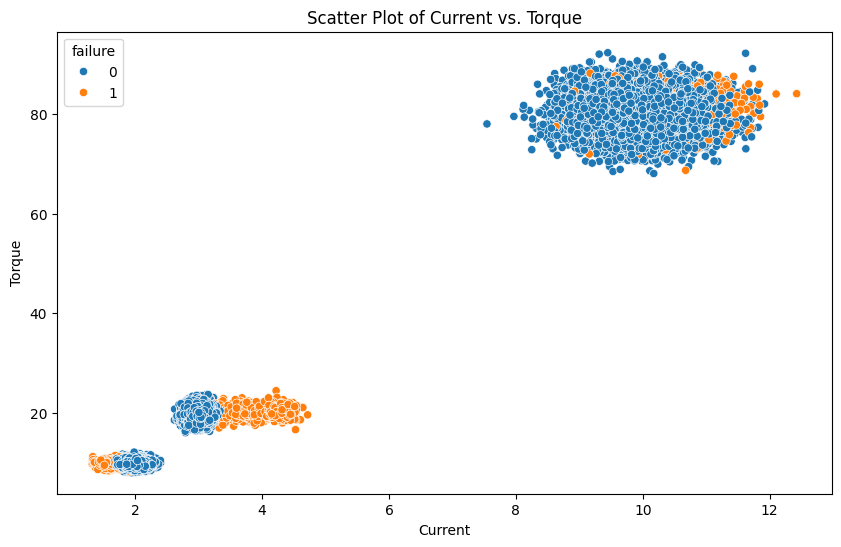

In [9]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='current', y='torque', hue='failure', data=df)
plt.title('Scatter Plot of Current vs. Torque')
plt.xlabel('Current')
plt.ylabel('Torque')
plt.show()

In [10]:
df = df.drop('Failure_Type', axis=1)
display(df.head())
df = pd.get_dummies(df, columns=['machine_type','production_line'])
display(df)

,timestamp,production_line,machine_id,machine_type,temperature,vibration,current,torque,total_working_hours,failure
0,2024-01-01 00:00:00,Line_3,8,Convoyeur,27.97,0.4722,3.260,19.92,0.0,0
1,2024-01-01 00:00:03,Line_1,3,Machine_de_finition,35.09,0.2203,1.996,10.23,0.0,0
2,2024-01-01 00:00:03,Line_3,9,Machine_de_finition,35.08,0.2049,2.221,9.67,0.0,0
3,2024-01-01 00:00:11,Line_2,4,Fraiseuse,46.49,1.6490,9.848,78.67,0.0,0
4,2024-01-01 00:00:11,Line_4,12,Machine_de_finition,34.51,0.2211,2.209,9.48,0.0,0


,timestamp,machine_id,temperature,vibration,current,torque,total_working_hours,failure,machine_type_Convoyeur,machine_type_Fraiseuse,machine_type_Machine_de_finition,production_line_Line_1,production_line_Line_2,production_line_Line_3,production_line_Line_4
0,2024-01-01 00:00:00,8,27.97,0.4722,3.260,19.92,0.00,0,True,False,False,False,False,True,False
1,2024-01-01 00:00:03,3,35.09,0.2203,1.996,10.23,0.00,0,False,False,True,True,False,False,False
2,2024-01-01 00:00:03,9,35.08,0.2049,2.221,9.67,0.00,0,False,False,True,False,False,True,False
3,2024-01-01 00:00:11,4,46.49,1.6490,9.848,78.67,0.00,0,False,True,False,False,True,False,False
4,2024-01-01 00:00:11,12,34.51,0.2211,2.209,9.48,0.00,0,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69115,2024-02-29 23:45:19,6,35.55,0.1393,2.038,10.52,1439.75,0,False,False,True,False,True,False,False
69116,2024-02-29 23:45:20,11,30.21,0.3845,3.176,18.60,1439.75,0,True,False,False,False,False,False,True
69117,2024-02-29 23:45:22,10,44.82,1.2242,9.500,77.43,1439.75,0,False,True,False,False,False,False,True
69118,2024-02-29 23:45:22,5,28.97,0.4026,3.039,19.18,1439.75,0,True,False,False,False,True,False,False


In [11]:
print(df.dtypes)

timestamp                           datetime64[ns]
machine_id                                   int64
temperature                                float64
vibration                                  float64
current                                    float64
torque                                     float64
total_working_hours                        float64
failure                                      int64
machine_type_Convoyeur                        bool
machine_type_Fraiseuse                        bool
machine_type_Machine_de_finition              bool
production_line_Line_1                        bool
production_line_Line_2                        bool
production_line_Line_3                        bool
production_line_Line_4                        bool
dtype: object


## After exploring the data and knowing the ones that have the most impact by weight

# starting building our model

In [14]:
from keras.models import Sequential, save_model
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 1. FIRST: Create proper 1-hour ahead labels per machine
print("Creating 1-hour ahead labels per machine...")

# Sort data by machine_id and timestamp to ensure proper time ordering
df_sorted = df.sort_values(['machine_id', 'timestamp']).reset_index(drop=True)

# Create 1-hour ahead failure labels (4 samples = 1 hour based on your data generation)
def create_future_labels(group_df, horizon_samples=4):
    """Create labels for 'failure within next N samples'"""
    group_df = group_df.copy()
    # Check if any failure occurs in the next 'horizon_samples' periods
    group_df['failure_in_1h'] = group_df['failure'].rolling(
        window=horizon_samples, min_periods=1
    ).max().shift(-horizon_samples)
    # Fill NaN values at the end with 0 (no future data available)
    group_df['failure_in_1h'] = group_df['failure_in_1h'].fillna(0).astype(int)
    return group_df

# Apply to each machine separately to avoid cross-machine contamination
df_with_labels = []
for machine_id in df_sorted['machine_id'].unique():
    machine_data = df_sorted[df_sorted['machine_id'] == machine_id].copy()
    machine_labeled = create_future_labels(machine_data, horizon_samples=4)  # 4 samples = 1 hour
    df_with_labels.append(machine_labeled)

df_labeled = pd.concat(df_with_labels, ignore_index=True)

print(f"Added failure_in_1h column. Distribution: {df_labeled['failure_in_1h'].value_counts().to_dict()}")

# 2. Prepare sequences per machine (avoid data leakage between machines)
features = ['temperature', 'vibration', 'current', 'torque', 'total_working_hours',
            'machine_type_Convoyeur', 'machine_type_Fraiseuse', 'machine_type_Machine_de_finition',
            'production_line_Line_1', 'production_line_Line_2', 'production_line_Line_3', 'production_line_Line_4'] # Include one-hot encoded features
sequence_length = 24  # 6 hours of history (4 samples per hour * 6 = 24)

# Create a copy of df_labeled without timestamp specifically for sequence creation
df_for_sequences = df_labeled.drop('timestamp', axis=1).copy()

def create_sequences(group_df, seq_len, feature_cols):
    """Create sequences from a single machine's data"""
    data = group_df[feature_cols].values
    targets = group_df['failure_in_1h'].values
    indices = group_df.index.values

    X, y, idx = [], [], []

    for i in range(len(data) - seq_len + 1):
        X.append(data[i:i+seq_len])
        y.append(targets[i+seq_len-1])  # Target at end of sequence
        idx.append(indices[i+seq_len-1])   # Original dataframe index

    return np.array(X), np.array(y), np.array(idx)

# Create sequences per machine and combine using df_for_sequences
all_X, all_y, all_indices = [], [], []

for machine_id in df_for_sequences['machine_id'].unique():
    machine_data = df_for_sequences[df_for_sequences['machine_id'] == machine_id]
    if len(machine_data) >= sequence_length:
        X_machine, y_machine, idx_machine = create_sequences(
            machine_data, sequence_length, features
        )
        all_X.append(X_machine)
        all_y.append(y_machine)
        all_indices.append(idx_machine)

# Combine all machines
X = np.vstack(all_X)
y = np.concatenate(all_y)
indices = np.concatenate(all_indices)

print(f"Created {len(X)} sequences with shape {X.shape}")
print(f"Target distribution: {np.bincount(y)}")

# 3. Scale features (fit scaler on training data only)
# Reshape for scaling: (samples * timesteps, features)
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)

# Split indices first to ensure proper train/test separation
train_indices, test_indices = train_test_split(
    range(len(X)), test_size=0.2, random_state=42, stratify=y
)

# Scale based on training data only
scaler = MinMaxScaler(feature_range=(0, 1))
# Select only the columns to be scaled (numeric features)
numeric_feature_indices = [features.index(col) for col in ['temperature', 'vibration', 'current', 'torque', 'total_working_hours']]
X_train_numeric_reshaped = X_reshaped[np.repeat(train_indices, n_timesteps)][:, numeric_feature_indices]
scaler.fit(X_train_numeric_reshaped)

# Scale only the numeric features in all data
X_scaled_reshaped = X_reshaped.copy()
X_scaled_reshaped[:, numeric_feature_indices] = scaler.transform(X_reshaped[:, numeric_feature_indices])
X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# Final train/test split
X_train, X_test = X_scaled[train_indices], X_scaled[test_indices]
y_train, y_test = y[train_indices], y[test_indices]
indices_train, indices_test = indices[train_indices], indices[test_indices]


# Explicitly convert training data to float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)


print(f"Training set: {X_train.shape}, positive rate: {y_train.mean():.3f}")
print(f"Test set: {X_test.shape}, positive rate: {y_test.mean():.3f}")


# 4. Build and train LSTM model
model = Sequential([
    LSTM(units=64, activation='tanh', input_shape=(sequence_length, len(features)),
         return_sequences=False),
    Dropout(0.3),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weight_dict}")

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Training LSTM model...")
history = model.fit(
    X_train, y_train,
    epochs=30,  # Reverted to 30 epochs to match original code
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    verbose=1
)

# 5. Evaluate model
print("\n=== Model Evaluation ===")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# 6. Make predictions on ALL sequences (both train and test)
print("\n=== Making Predictions ===")
# Use X_scaled for predictions, which was created from df_for_sequences (without timestamp)
y_pred_proba = model.predict(X_scaled.astype(np.float32), verbose=0).flatten()
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

# 7. CREATE THE PREDICTED COLUMN - Map predictions back to df_labeled (which still has timestamp)
print("Adding predicted columns to dataframe...")

# Initialize prediction columns on df_labeled (which has the timestamp)
df_labeled['predicted_failure_1h_prob'] = np.nan
df_labeled['predicted_failure_1h'] = 0

# Map predictions back using stored indices
# indices array contains the original index from df_labeled.
for i, orig_idx in enumerate(indices):
     df_labeled.loc[orig_idx, 'predicted_failure_1h_prob'] = y_pred_proba[i]
     df_labeled.loc[orig_idx, 'predicted_failure_1h'] = y_pred_binary[i]


# Fill remaining NaN values with 0 (sequences that couldn't be formed)
df_labeled['predicted_failure_1h_prob'] = df_labeled['predicted_failure_1h_prob'].fillna(0)
df_labeled['predicted_failure_1h'] = df_labeled['predicted_failure_1h'].fillna(0).astype(int)


print(f"\nPrediction column added!")
print(f"Predicted positive rate: {df_labeled['predicted_failure_1h'].mean():.3f}")
print(f"Actual 1h-ahead failure rate: {df_labeled['failure_in_1h'].mean():.3f}")

# 8. Show sample results
print("\n=== Sample Results ===")
# Now use df_labeled for displaying results as it has the timestamp
sample_data = df_labeled[df_labeled['predicted_failure_1h_prob'] > 0].head(10)
display_cols = ['timestamp', 'machine_id', 'failure', 'failure_in_1h',
                'predicted_failure_1h_prob', 'predicted_failure_1h']
print("Top 10 rows with predictions > 0:")
display(sample_data[display_cols])

# 9. Performance metrics on sequences with predictions
# Use df_labeled for evaluation
valid_predictions_mask = ~df_labeled['predicted_failure_1h_prob'].isna()
valid_actual = df_labeled[valid_predictions_mask]['failure_in_1h']
valid_predicted = df_labeled[valid_predictions_mask]['predicted_failure_1h']
valid_proba = df_labeled[valid_predictions_mask]['predicted_failure_1h_prob']

print(f"\n=== Classification Report ===")
print(classification_report(valid_actual, valid_predicted))

print(f"\n=== Confusion Matrix ===")
print(confusion_matrix(valid_actual, valid_predicted))

# 10. Show final dataframe with predictions
print(f"\nFinal dataframe shape: {df_labeled.shape}")
print("Columns:", df_labeled.columns.tolist())

# Quick verification - show some high-probability predictions
high_risk = df_labeled[df_labeled['predicted_failure_1h_prob'] > 0.7]
if len(high_risk) > 0:
    print(f"\nFound {len(high_risk)} high-risk predictions (prob > 0.7)")
    display(high_risk[['timestamp', 'machine_id', 'failure_in_1h', 'predicted_failure_1h_prob']].head())
else:
    print("\nNo high-probability failure predictions found")

# Save results
# Save the df_labeled (which has the timestamp and predictions)
df_labeled.to_csv('production_data_with_predictions.csv', index=False)
print("Results saved to 'production_data_with_predictions.csv'")

# Save the trained model in the native Keras format
save_model(model, 'predictive_maintenance_model.keras')
print("Trained model saved to 'predictive_maintenance_model.keras'")

Creating 1-hour ahead labels per machine...
Added failure_in_1h column. Distribution: {0: 66300, 1: 2820}
Created 68844 sequences with shape (68844, 24, 12)
Target distribution: [66024  2820]
Training set: (55075, 24, 12), positive rate: 0.041
Test set: (13769, 24, 12), positive rate: 0.041
Class weights: {0: np.float64(0.5213559514568621), 1: np.float64(12.20633865248227)}
Training LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7124 - loss: 0.4062 - precision: 0.1249 - recall: 0.9186 - val_accuracy: 0.8838 - val_loss: 0.1836 - val_precision: 0.2519 - val_recall: 0.9326
Epoch 2/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8756 - loss: 0.2015 - precision: 0.2392 - recall: 0.9060 - val_accuracy: 0.9593 - val_loss: 0.1078 - val_precision: 0.5014 - val_recall: 0.9220
Epoch 3/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9285 - loss: 0.1422 - precision: 0.3651 - recall: 0.9456 - val_accuracy: 0.9185 - val_loss: 0.1995 - val_precision: 0.3263 - val_recall: 0.9291
Epoch 4/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9300 - loss: 0.1342 - precision: 0.3605 - recall: 0.9582 - val_accuracy: 0.9638 - val_loss: 0.0902 - val_precision: 0.5325 - val_recall: 0.9592
Epoch 5/30
861/861 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9368 - loss: 0.1299 - precision: 0.3899 - recall: 0.9560 - val_accuracy: 0.9683 - va

,timestamp,machine_id,failure,failure_in_1h,predicted_failure_1h_prob,predicted_failure_1h
23,2024-01-01 05:45:12,1,0,0,8.059816e-09,0
24,2024-01-01 06:00:12,1,0,0,7.822755e-09,0
25,2024-01-01 06:15:12,1,0,0,8.086409e-09,0
26,2024-01-01 06:30:12,1,0,0,8.619124e-09,0
27,2024-01-01 06:45:12,1,0,0,8.087164e-09,0
28,2024-01-01 07:00:12,1,0,0,5.802653e-09,0
29,2024-01-01 07:15:12,1,0,0,7.827516e-09,0
30,2024-01-01 07:30:12,1,0,0,9.071542e-09,0
31,2024-01-01 07:45:12,1,0,0,6.525195e-09,0
32,2024-01-01 08:00:12,1,0,0,8.596139e-09,0



=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     66300
           1       0.63      0.99      0.77      2820

    accuracy                           0.98     69120
   macro avg       0.82      0.98      0.88     69120
weighted avg       0.98      0.98      0.98     69120


=== Confusion Matrix ===
[[64678  1622]
 [   22  2798]]

Final dataframe shape: (69120, 18)
Columns: ['timestamp', 'machine_id', 'temperature', 'vibration', 'current', 'torque', 'total_working_hours', 'failure', 'machine_type_Convoyeur', 'machine_type_Fraiseuse', 'machine_type_Machine_de_finition', 'production_line_Line_1', 'production_line_Line_2', 'production_line_Line_3', 'production_line_Line_4', 'failure_in_1h', 'predicted_failure_1h_prob', 'predicted_failure_1h']

Found 3439 high-risk predictions (prob > 0.7)


,timestamp,machine_id,failure_in_1h,predicted_failure_1h_prob
4512,2024-02-17 00:00:12,1,0,0.767085
4515,2024-02-17 00:45:12,1,0,0.757139
4516,2024-02-17 01:00:12,1,0,0.808008
4517,2024-02-17 01:15:12,1,0,0.836731
4518,2024-02-17 01:30:12,1,0,0.827483


Results saved to 'production_data_with_predictions.csv'
Trained model saved to 'predictive_maintenance_model.keras'


In [17]:
#===========================================
# ADD THIS CODE AFTER YOUR EXISTING CODE
# ===========================================
# This enhances your current implementation without replacing it

print("\n" + "="*60)
print("🚀 ENHANCED VERSION - BIDIRECTIONAL LSTM WITH ATTENTION")
print("="*60)

# Additional imports needed for enhanced version
from keras.layers import Bidirectional, Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit

def create_enhanced_lstm_model(sequence_length, n_features):
    """
    Enhanced LSTM with Bidirectional layers and attention mechanism
    """
    inputs = Input(shape=(sequence_length, n_features))

    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(inputs)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(x)

    # Simple attention mechanism
    attention_weights = Dense(1, activation='tanh')(x)
    attention_weights = Dense(1, activation='softmax')(attention_weights)

    # Apply attention and final LSTM
    x_weighted = x * attention_weights
    x = LSTM(32, dropout=0.2, return_sequences=False)(x_weighted)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def enhanced_feature_scaling(X, train_indices, test_indices):
    """
    Enhanced scaling using RobustScaler to handle outliers better
    """
    print("🔧 Applying enhanced RobustScaler (better for industrial data)...")

    n_samples, n_timesteps, n_features = X.shape

    # Reshape and scale properly
    X_train_for_scaling = X[train_indices].reshape(-1, n_features)

    # Use RobustScaler instead of MinMaxScaler for better outlier handling
    enhanced_scaler = RobustScaler()
    enhanced_scaler.fit(X_train_for_scaling)

    # Scale all data
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = enhanced_scaler.transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    return X_scaled, enhanced_scaler

def setup_enhanced_callbacks():
    """
    Advanced callbacks for better training control
    """
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1,
            start_from_epoch=5  # Don't start early stopping too early
        ),
        ModelCheckpoint(
            'enhanced_best_model.keras',  # Use modern .keras format
            monitor='val_loss',
            save_best_only=True,
            verbose=1,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=1
        )
    ]
    return callbacks

def enhanced_model_evaluation(model, X_test, y_test, scaler, threshold=0.5):
    """
    Comprehensive evaluation with additional metrics
    """
    from sklearn.metrics import roc_auc_score, precision_recall_curve
    import matplotlib.pyplot as plt

    # Make predictions
    y_pred_proba = model.predict(X_test, verbose=0).flatten()
    y_pred_binary = (y_pred_proba >= threshold).astype(int)

    # Calculate AUC-ROC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"\n📊 ENHANCED EVALUATION METRICS:")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Threshold used: {threshold}")

    # Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Find optimal threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

    print(f"Optimal threshold for F1: {optimal_threshold:.3f}")
    print(f"F1-score at optimal threshold: {f1_scores[optimal_idx]:.4f}")

    # Classification report with optimal threshold
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    print(f"\n📋 Classification Report (optimal threshold):")
    print(classification_report(y_test, y_pred_optimal))

    return {
        'auc_score': auc_score,
        'optimal_threshold': optimal_threshold,
        'y_pred_proba': y_pred_proba,
        'y_pred_binary': y_pred_binary,
        'y_pred_optimal': y_pred_optimal
    }

# ===========================================
# ENHANCED TRAINING PIPELINE
# ===========================================

print("\n🔄 STARTING ENHANCED TRAINING...")

# Use your existing data but with enhanced scaling
print("Step 1: Enhanced feature scaling...")
X_enhanced_scaled, enhanced_scaler = enhanced_feature_scaling(X, train_indices, test_indices)

# Split with enhanced scaling
X_train_enhanced = X_enhanced_scaled[train_indices]
X_test_enhanced = X_enhanced_scaled[test_indices]

print(f"Enhanced training set: {X_train_enhanced.shape}")
print(f"Enhanced test set: {X_test_enhanced.shape}")

# Create enhanced model
print("\nStep 2: Building enhanced bidirectional LSTM model...")
enhanced_model = create_enhanced_lstm_model(sequence_length, len(features))

# Compile with same settings but show model summary
enhanced_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("📋 Enhanced Model Architecture:")
enhanced_model.summary()

# Setup enhanced callbacks
enhanced_callbacks = setup_enhanced_callbacks()

# Train enhanced model
print("\nStep 3: Training enhanced model with advanced callbacks...")
enhanced_history = enhanced_model.fit(
    X_train_enhanced, y_train,
    epochs=100,  # More epochs with early stopping
    batch_size=32,  # Smaller batch size for better gradients
    validation_data=(X_test_enhanced, y_test),
    class_weight=class_weight_dict,
    callbacks=enhanced_callbacks,
    verbose=1
)

# Enhanced evaluation
print("\nStep 4: Enhanced evaluation...")
enhanced_results = enhanced_model_evaluation(
    enhanced_model, X_test_enhanced, y_test, enhanced_scaler, threshold=0.5
)

# ===========================================
# COMPARISON WITH ORIGINAL MODEL
# ===========================================

print("\n" + "="*60)
print("📊 COMPARISON: ORIGINAL vs ENHANCED")
print("="*60)

# Evaluate original model for comparison
original_pred_proba = model.predict(X_test, verbose=0).flatten()
original_auc = roc_auc_score(y_test, original_pred_proba)

print(f"Original Model AUC-ROC: {original_auc:.4f}")
print(f"Enhanced Model AUC-ROC: {enhanced_results['auc_score']:.4f}")
print(f"Improvement: {enhanced_results['auc_score'] - original_auc:.4f}")

# ===========================================
# ENHANCED PREDICTIONS ON ALL DATA
# ===========================================

print("\n🎯 Making enhanced predictions on all data...")

# Scale all data with enhanced scaler
X_all_enhanced = enhanced_scaler.transform(X_reshaped).reshape(n_samples, n_timesteps, n_features)

# Enhanced predictions
y_pred_proba_enhanced = enhanced_model.predict(X_all_enhanced, verbose=0).flatten()
y_pred_binary_enhanced = (y_pred_proba_enhanced >= enhanced_results['optimal_threshold']).astype(int)

# Add enhanced predictions to dataframe
df_labeled['enhanced_pred_prob'] = np.nan
df_labeled['enhanced_pred_binary'] = 0
df_labeled['enhanced_risk_level'] = 'Low'

# Map enhanced predictions back
for i, orig_idx in enumerate(indices):
    df_labeled.loc[orig_idx, 'enhanced_pred_prob'] = y_pred_proba_enhanced[i]
    df_labeled.loc[orig_idx, 'enhanced_pred_binary'] = y_pred_binary_enhanced[i]

    # Enhanced risk categorization
    if y_pred_proba_enhanced[i] >= 0.8:
        risk = 'Critical'
    elif y_pred_proba_enhanced[i] >= 0.6:
        risk = 'High'
    elif y_pred_proba_enhanced[i] >= 0.3:
        risk = 'Medium'
    else:
        risk = 'Low'
    df_labeled.loc[orig_idx, 'enhanced_risk_level'] = risk

# Fill NaN values
df_labeled['enhanced_pred_prob'] = df_labeled['enhanced_pred_prob'].fillna(0)

# ===========================================
# ENHANCED RESULTS SUMMARY
# ===========================================

print("\n" + "="*60)
print("🎉 ENHANCED RESULTS SUMMARY")
print("="*60)

print(f"Enhanced model predictions completed!")
print(f"Using optimal threshold: {enhanced_results['optimal_threshold']:.3f}")

# Risk distribution
risk_dist = df_labeled['enhanced_risk_level'].value_counts()
print(f"\n📊 Enhanced Risk Distribution:")
for risk, count in risk_dist.items():
    print(f"  {risk}: {count} cases ({count/len(df_labeled)*100:.1f}%)")

# Show high-risk cases
critical_high_risk = df_labeled[
    df_labeled['enhanced_risk_level'].isin(['Critical', 'High'])
].sort_values('enhanced_pred_prob', ascending=False)

if len(critical_high_risk) > 0:
    print(f"\n🚨 Top 10 High-Risk Maintenance Alerts:")
    display_cols = ['timestamp', 'machine_id', 'failure_in_1h',
                   'enhanced_pred_prob', 'enhanced_risk_level']
    print(critical_high_risk[display_cols].head(10))

    print(f"\n📈 Comparison of Predictions:")
    comparison_cols = ['timestamp', 'machine_id', 'predicted_failure_1h_prob',
                      'enhanced_pred_prob', 'enhanced_risk_level']
    print("Original vs Enhanced - Top Risk Cases:")
    print(critical_high_risk[comparison_cols].head(5))

# Save enhanced results
df_labeled.to_csv('enhanced_production_data_with_predictions.csv', index=False)
print(f"\n💾 Enhanced results saved to 'enhanced_production_data_with_predictions.csv'")

# Save enhanced model
enhanced_model.save('enhanced_lstm_model.keras')
print(f"💾 Enhanced model saved to 'enhanced_lstm_model.keras'")

print("\n" + "="*60)
print("✅ ENHANCEMENT COMPLETE!")
print("="*60)
print("Your original model is preserved, and you now have:")
print("✓ Bidirectional LSTM with attention mechanism")
print("✓ RobustScaler for better outlier handling")
print("✓ Advanced callbacks (EarlyStopping, ModelCheckpoint, LR reduction)")
print("✓ Comprehensive evaluation with optimal threshold")
print("✓ Enhanced risk categorization (Low/Medium/High/Critical)")
print("✓ Modern .keras model format")
print("✓ Side-by-side comparison with original model")


🚀 ENHANCED VERSION - BIDIRECTIONAL LSTM WITH ATTENTION

🔄 STARTING ENHANCED TRAINING...
Step 1: Enhanced feature scaling...
🔧 Applying enhanced RobustScaler (better for industrial data)...
Enhanced training set: (55075, 24, 12)
Enhanced test set: (13769, 24, 12)

Step 2: Building enhanced bidirectional LSTM model...
📋 Enhanced Model Architecture:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 24, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 24, 256)   │    144,384 │ input_layer_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 24, 128)   │    164,352 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 24, 1)     │        129 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 24, 1)     │          2 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 24, 128)   │          0 │ bidirectional_5[… │
│ (Multiply)          │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 32)        │     20,608 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      2,112 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         33 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 333,700 (1.27 MB)

 Trainable params: 333,700 (1.27 MB)

 Non-trainable params: 0 (0.00 B)


Step 3: Training enhanced model with advanced callbacks...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 24, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1722/1722 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8090 - loss: 0.4330 - precision: 0.1561 - recall: 0.7923
Epoch 1: val_loss improved from inf to 0.15806, saving model to enhanced_best_model.keras
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 211s 117ms/step - accuracy: 0.8090 - loss: 0.4330 - precision: 0.1561 - recall: 0.7923 - val_accuracy: 0.9658 - val_loss: 0.1581 - val_precision: 0.5581 - val_recall: 0.7926 - learning_rate: 0.0010
Epoch 2/100
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8922 - loss: 0.2785 - precision: 0.2569 - recall: 0.8532
Epoch 2: val_loss improved from 0.15806 to 0.14815, saving model to enhanced_best_model.keras
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 201s 117ms/step - accuracy: 0.8922 - loss: 0.2785 - precision: 0.2569 - recall: 0.8532 - val_accuracy: 0.9468 - val_loss: 0.1481 - val_precision: 0.4199 - val_recall: 0.7855 - learning_rate: 0.0010
Epoch 3/100
1722/1722 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8974 - loss: 0.2437 - precision: 0.2756 - r

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 24, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



📊 ENHANCED EVALUATION METRICS:
AUC-ROC Score: 0.9847
Threshold used: 0.5
Optimal threshold for F1: 0.598
F1-score at optimal threshold: 0.8615

📋 Classification Report (optimal threshold):
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13205
         1.0       0.94      0.79      0.86       564

    accuracy                           0.99     13769
   macro avg       0.97      0.90      0.93     13769
weighted avg       0.99      0.99      0.99     13769


📊 COMPARISON: ORIGINAL vs ENHANCED
Original Model AUC-ROC: 0.9985
Enhanced Model AUC-ROC: 0.9847
Improvement: -0.0139

🎯 Making enhanced predictions on all data...

🎉 ENHANCED RESULTS SUMMARY
Enhanced model predictions completed!
Using optimal threshold: 0.598

📊 Enhanced Risk Distribution:
  Low: 62525 cases (90.5%)
  Medium: 4138 cases (6.0%)
  Critical: 2200 cases (3.2%)
  High: 257 cases (0.4%)

🚨 Top 10 High-Risk Maintenance Alerts:
                timestamp  machine_id  f

In [16]:
df_predicted = pd.read_csv('/content/production_data_with_predictions.csv')
df_predicted.head(20)
df_predicted = df_predicted[df_predicted['predicted_failure_1h'] == 1]
df_predicted

,timestamp,machine_id,temperature,vibration,current,torque,total_working_hours,failure,machine_type_Convoyeur,machine_type_Fraiseuse,machine_type_Machine_de_finition,production_line_Line_1,production_line_Line_2,production_line_Line_3,production_line_Line_4,failure_in_1h,predicted_failure_1h_prob,predicted_failure_1h
4440,2024-02-16 06:00:12,1,47.20,1.6895,10.782,85.84,1110.00,0,False,True,False,True,False,False,False,0,0.548911,1
4442,2024-02-16 06:30:12,1,47.15,1.6452,9.868,83.84,1110.50,0,False,True,False,True,False,False,False,0,0.532388,1
4483,2024-02-16 16:45:12,1,46.47,1.5207,11.012,77.68,1120.75,0,False,True,False,True,False,False,False,0,0.562211,1
4502,2024-02-16 21:30:12,1,40.84,1.2246,9.652,80.55,1125.50,0,False,True,False,True,False,False,False,0,0.518816,1
4505,2024-02-16 22:15:12,1,48.31,1.7272,9.957,78.04,1126.25,0,False,True,False,True,False,False,False,0,0.558650,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68742,2024-02-26 01:30:11,12,35.53,0.1826,1.955,9.36,1345.50,0,False,False,True,False,False,False,True,0,0.549726,1
68744,2024-02-26 02:00:11,12,34.98,0.2566,2.011,9.93,1346.00,0,False,False,True,False,False,False,True,0,0.508492,1
68745,2024-02-26 02:15:11,12,34.65,0.2921,2.245,11.67,1346.25,0,False,False,True,False,False,False,True,0,0.562723,1
68746,2024-02-26 02:30:11,12,35.09,0.1769,2.082,10.48,1346.50,0,False,False,True,False,False,False,True,0,0.524601,1
